<a href="https://colab.research.google.com/github/Brunoxue/hsi_examples/blob/main/efa_tite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Endmembers on TI and TE dataset with Python


## 1. Download the Dataset from Github
Downloads the dataset by cloning the tite GitHub repository to the local environment. The dataset is stored in a folder named tite.

In [1]:
# Get dataset from Github repo
!git clone https://github.com/Brunoxue/tite.git

Cloning into 'tite'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 40.42 MiB | 14.44 MiB/s, done.


## 2. Importing Required Libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

## 3. Loading the Dataset
First, we can load the variables from the tite_reflectance.mat file into the Python environment.

In [ ]:
# Load the .mat file (use scipy.io.loadmat for this)
from scipy.io import loadmat
data = loadmat('tite/tite_reflectance.mat')

# Extract hsi from loaded data
hsi = data['TE2'].astype(np.double)

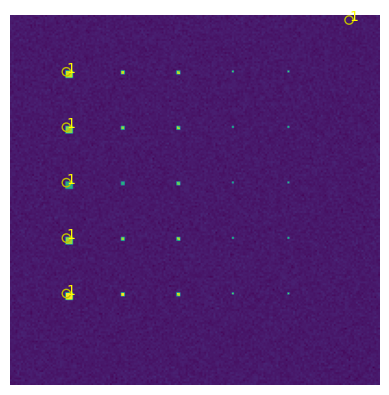

In [6]:
# Automatic Target Generation Process (ATGP)
def ATGP(HSI,p):
  '''
  HSI: Hyperspectral Image
  p: Number of targets
  '''
  (x,y,L)=HSI.shape
  N=x*y
  r=np.reshape(HSI,(N,L))

  idxTgt = [np.argmax(np.sum(r*r,axis=1))]
  spTgt = r[idxTgt,:].squeeze()

  for idx in range(1,6):
    U = spTgt.T

    if U.ndim == 1:
      P_U_per = np.eye(L)-U@U.T/(U.T@U)
    else:
      P_U_per = np.eye(L)-U@np.linalg.pinv(U.T@U)@U.T

    scoreATGP = r@P_U_per*r
    idxNewTgt = np.argmax(np.sum(scoreATGP,axis=1))

    spTgt=np.vstack((spTgt,r[idxNewTgt,:].squeeze()))
    idxTgt.append(idxNewTgt)

  posTgt = np.unravel_index(idxTgt, (x,y), order='C')

  return posTgt, spTgt

# Define the number of endmembers
numTgt = 6

posTgt, spTgt = ATGP(hsi,numTgt)

plt.figure()
plt.imshow(hsi[:, :, 100])
plt.axis('off')

for pos_x, pos_y in zip(posTgt[1], posTgt[0]):
    plt.scatter(pos_x, pos_y, facecolors='none', edgecolors='y')  # Plot target points
    plt.text(pos_x, pos_y, str(idx + 1), color='yellow')  # Label target points

plt.show()

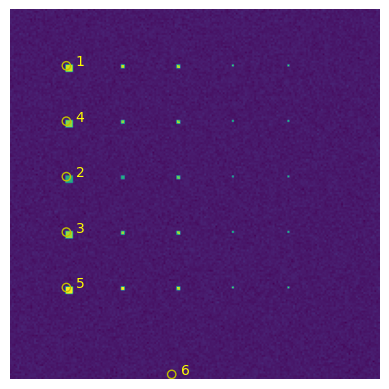

In [9]:

def SGA(imagecube, p):
  n = 1
  initial = 0
  row, column, band = imagecube.shape

  # Determine whether to use SVD
  use_svd = band > p

  # Randomly select an initial point
  endmemberindex = np.array([[np.random.randint(row)], [np.random.randint(column)]])

  # Main loop
  while n < p:
      # Generate endmember vector from reduced cube
      endmember = []
      for i in range(n):
          if use_svd:
              endmember.append(imagecube[endmemberindex[0, i], endmemberindex[1, i], :])
          else:
              endmember.append(imagecube[endmemberindex[0, i], endmemberindex[1, i], :n])
      endmember = np.array(endmember).T

      # Find new endmember point
      newendmemberindex = []
      maxvolume = 0
      for i in range(row):
          for j in range(column):
              if use_svd:
                  jointpoint = np.hstack((endmember, imagecube[i, j, :].reshape(-1, 1)))
                  s = svd(jointpoint, compute_uv=False)
                  volume = np.prod(s[:n + 1])
              else:
                  jointpoint = np.hstack((endmember, imagecube[i, j, :n].reshape(-1, 1)))
                  jointmatrix = np.vstack((np.ones((1, n + 1)), jointpoint.T))
                  volume = np.abs(np.linalg.det(jointmatrix)) / np.math.factorial(n)

              if volume > maxvolume:
                  maxvolume = volume
                  newendmemberindex = [i, j]

      endmemberindex = np.hstack((endmemberindex, np.array(newendmemberindex).reshape(2, 1)))
      n += 1

      if initial == 0:
          n = 1
          endmemberindex = endmemberindex[:, 1:]
          initial += 1

  # Switch the results back to X and Y
  endmemberindex = np.vstack((endmemberindex[1, :], endmemberindex[0, :]))

  return endmemberindex.T

# Define the number of endmembers
numTgt = 6

# Call SGA function to get target positions
posTgt = SGA(hsi, numTgt)

# Plot the image and target points
plt.figure()
plt.imshow(hsi[:, :, 100])
plt.axis('off')

for idx in range(numTgt):
    plt.scatter(posTgt[idx, 0], posTgt[idx, 1], facecolors='none', edgecolors='y')  # Plot target points
    plt.text(posTgt[idx, 0] + 5, posTgt[idx, 1], str(idx + 1), color='yellow')  # Label target points

plt.show()